## BS6207 Assignment3

Given a 32x32 pixels, 3 channels input. Fill the pixel values with torch.randn( . . . ) For each pytorch functions in the list,

Initialise the weights with uniform random numbers r

Call the functions and get the output tensors - torch_out

Implement these functions from scratch, without using any neural network libraries. Use linear algebra libraries in python is ok. Output your tensors as — my_out

Compare and show that torch_out and my_out are equal up to small numerical errors

In [ ]:
import torch
torch.manual_seed(0)

#initiate the input as Batch_size, Channel, height, width 1*3*32*32

inputs = torch.randn(1,3, 32, 32)
inputs.shape
input_np = inputs.numpy()
input_np.shape

### 1. Max Pooling

Max pooling is a sample-based discretization process. The objective is to down-sample an input representation (image, hidden-layer output matrix, etc.), reducing its dimensionality and allowing for assumptions to be made about features contained in the sub-regions binned.

#### For what?

This is done to in part to help over-fitting by providing an abstracted form of the representation. 

#### How?
take the maximum of a window in the input moving with step  stride.

#### parameters:
kernel_size: int, the size of the window

stride: int, the stride of the window
        
padding: int, implicit zero paddings on both sides of the input


In [8]:
MaxPool=torch.nn.MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, return_indices=False, ceil_mode=False)
torch_out=MaxPool(inputs)
torch_out = torch_out.numpy()
torch_out.shape

(1, 3, 31, 31)

#### My implemention of max pooling

In [10]:
import numpy as np
from numpy.lib.stride_tricks import as_strided

def pool2d(img, kernel_size, stride, padding, pool_mode='max'):
    '''
    2D Pooling
    Parameters:
        A: input 2D array
        kernel_size: int, the size of the window
        stride: int, the stride of the window
        padding: int, implicit zero paddings on both sides of the input
        pool_mode: string, 'max' or 'avg'
    '''
    # Padding
    

    # Window view of A
    
    my_out = np.empty((1,3,(img.shape[2] - kernel_size)//stride + 1,
                    (img.shape[3] - kernel_size)//stride + 1), dtype = float)
    
    for batch in img:
        i = 0
        for A in batch:
            A = np.pad(A, padding, mode='constant')
            
            output_shape = ((A.shape[0] - kernel_size)//stride + 1,
                    (A.shape[1] - kernel_size)//stride + 1)
            kernel_sizes = (kernel_size, kernel_size)
            A_w = as_strided(A, shape = output_shape + kernel_sizes, 
                        strides = (stride*A.strides[0],
                                   stride*A.strides[1]) + A.strides)
            A_w = A_w.reshape(-1, *kernel_sizes)

    # Return the result of pooling
            if pool_mode == 'max':
                my_out[0,i] = A_w.max(axis=(1,2)).reshape(output_shape)
            elif pool_mode == 'avg':
                my_out[0,i] =  A_w.mean(axis=(1,2)).reshape(output_shape)
            i+=1
    return my_out

my_out = pool2d(input_np, kernel_size=2, stride=1, padding=0, pool_mode='max')
my_out.shape

(1, 3, 31, 31)

#### Are torch_out and my_out of max pooling equal?

In [11]:
(torch_out == my_out).all()

True

### 2. Average pooling

Average pooling is same as max pooling except it takes the average rather than the max within the window.

#### For what?

This is done to in part to help over-fitting by providing an abstracted form of the representation, which conserve more background information.

#### How?
take the average of a window in the input moving with step  stride.

#### parameters:
kernel_size: int, the size of the window

stride: int, the stride of the window
        
padding: int, implicit zero paddings on both sides of the input

In [7]:
AvgPool=torch.nn.AvgPool2d(kernel_size=2, stride=1, padding=0,ceil_mode=False, count_include_pad=True,divisor_override=None)
torch_out=AvgPool(inputs)
torch_out = torch_out.numpy()
torch_out.shape

(1, 3, 31, 31)

#### My implemention of average pooling

In [8]:
import numpy as np
from numpy.lib.stride_tricks import as_strided

def pool2d(A, kernel_size, stride, padding, pool_mode='max'):
    '''
    2D Pooling

    Parameters:
        A: input 2D array
        kernel_size: int, the size of the window
        stride: int, the stride of the window
        padding: int, implicit zero paddings on both sides of the input
        pool_mode: string, 'max' or 'avg'
    '''
    # Padding
    A = np.pad(A, padding, mode='constant')

    # Window view of A
    output_shape = ((A.shape[0] - kernel_size)//stride + 1,
                    (A.shape[1] - kernel_size)//stride + 1)
    kernel_size = (kernel_size, kernel_size)
    A_w = as_strided(A, shape = output_shape + kernel_size, 
                        strides = (stride*A.strides[0],
                                   stride*A.strides[1]) + A.strides)
    A_w = A_w.reshape(-1, *kernel_size)

    # Return the result of pooling
    if pool_mode == 'max':
        return A_w.max(axis=(1,2)).reshape(output_shape)
    elif pool_mode == 'avg':
        return A_w.mean(axis=(1,2)).reshape(output_shape)

my_out = np.empty((1,3,31,31), dtype = float)
for batch in input_np:
    i = 0
    for channel in batch:
        my_out[0,i] =  pool2d(channel, kernel_size=2, stride=1, padding=0, pool_mode='avg')
        i+=1

#### Are torch_out and my_out of average pooling equal?

In [9]:
(torch_out == my_out).all()

True

### 3. Convolutional NN 
#### How:
you start with a kernel, which is simply a small matrix of weights. This kernel “slides” over the 2D input data, performing an elementwise multiplication with the part of the input it is currently on, and then summing up the results into a single output pixel.

#### Parameters:
Out channels: number of kernel(filter/feature maps)
Dilation = 1: the stride within the filter is 1
groups = 1:  in_channels and out_channels must both be divisible by 1.

In [260]:
#kernel_size=3, stride=1
torch.manual_seed(0)
Conv=torch.nn.Conv2d(in_channels=3, out_channels=6,kernel_size=3, stride=1, padding=0, dilation=1, groups=1,
                     bias=True, padding_mode='zeros')
torch_out=Conv(inputs)
torch_out.shape

torch.Size([1, 6, 30, 30])

In [233]:
weight = Conv.weight.data
bias = Conv.bias.data

In [311]:
def conv2d(inputs, weight, bias, stride):
    padding = 0
    N, C, H, W = inputs.shape
    filter_, _, kernel_H, kernel_W = weight.shape
    
    H_out= 1+(H+2*padding-kernel_H)//stride
    W_out= 1+(W+2*padding-kernel_W)//stride
    out = torch.zeros(N, filter_, H_out, W_out)
    
    for batch in range(N):
        for filter_i in range(filter_):
            for row in range(H_out):
                for col in range(W_out):
                    out[batch, filter_i, row, col] = torch.sum(inputs[batch, :, row*stride:row*stride + kernel_H, 
                                                                     col*stride:col*stride + kernel_W] *weight[filter_i, :,:,:]) + bias[filter_i]
                    
    return out

my_out = conv2d(inputs, weight, bias, 1)
my_out.shape

torch.Size([1, 6, 30, 30])

In [262]:
(torch_out - my_out<=0.000001).all()

tensor(True)

### 4. Conv 2D with Dilation

Dilation with different values are shown below, we are taking dilation = 2 here:
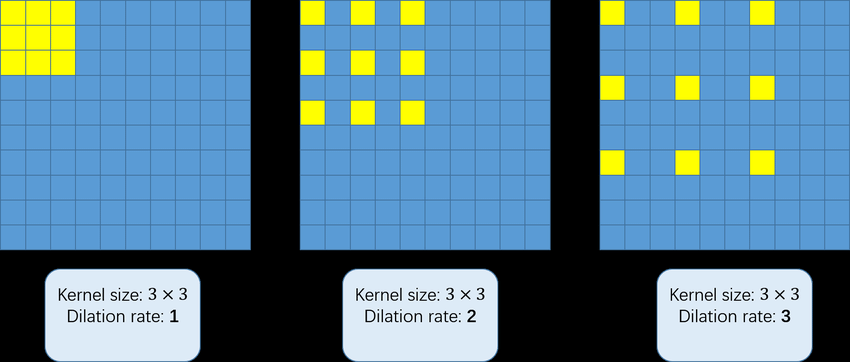

In [317]:
#kernel_size=5, stride=2
Conv=torch.nn.Conv2d(in_channels=3, out_channels=6,kernel_size=5, stride=2, padding=0, dilation=2, groups=1,
                     bias=True, padding_mode='zeros')
torch_out=Conv(inputs)
torch_out

tensor([[[[-5.4019e-03,  1.7909e-01, -1.0476e-01,  7.4469e-01,  5.9291e-01,
            2.9449e-01,  1.0095e+00, -7.7239e-01,  3.8286e-01,  2.2187e-01,
           -3.1923e-01, -2.4975e-01],
          [ 7.4679e-01,  6.7372e-03, -3.1795e-01, -9.2883e-01,  5.0674e-02,
            3.6113e-01,  1.1296e-01,  7.9236e-02, -2.0038e-01,  1.1906e-01,
           -1.5462e-01, -3.6292e-01],
          [ 5.3563e-01, -3.3586e-01,  3.1869e-01,  7.5129e-01, -7.1287e-02,
           -2.6119e-01, -2.1188e-01, -6.8061e-01, -8.6836e-01,  3.2121e-01,
           -8.6332e-01,  4.3371e-01],
          [ 5.5730e-01,  9.2158e-01,  1.9784e-01, -1.1340e-01,  4.6574e-02,
           -6.8409e-01, -5.3939e-01, -4.5286e-02,  1.1033e+00, -5.2885e-01,
            9.7801e-01, -1.0700e+00],
          [-9.3423e-01,  3.4281e-01, -2.9735e-01,  6.6228e-02, -1.2507e-01,
            1.1401e+00, -3.7330e-01, -8.3782e-01, -3.1296e-01, -1.1258e+00,
           -5.3248e-01,  9.1912e-01],
          [ 9.1617e-01,  3.6093e-01, -7.6088e-01, 

In [320]:
kernels = Conv.weight.data
bias = Conv.bias.data

def one_kernel_dilation(kernel, dilation):
    dilation_kernel = torch.zeros([len(kernel)+(dilation-1)*(len(kernel)-1), len(kernel)+(dilation-1)*(len(kernel)-1)])
    count = 0
    for i in range(0, len(dilation_kernel), dilation):
        for j in range(0, len(dilation_kernel), dilation):
            dilation_kernel[i][j] = kernel.flatten()[count]
            count+=1
    return dilation_kernel

def all_kernel_dilation(kernel, dilation):
    kernels = torch.zeros([len(kernel), len(kernel[0]), len(kernel[0][0])+(dilation-1)*(len(kernel[0][0])-1), len(kernel[0][0])+(dilation-1)*(len(kernel[0][0])-1)])
    for i in range(len(kernel)):
        for j in range(len(kernel[0])):
            kernels[i][j] = one_kernel_dilation(kernel[i][j], dilation)
    return kernels

def convolution2D(inputs, kernel, bias, stride, dilation):
    if dilation != 1:
        kernels = all_kernel_dilation(kernel, dilation=dilation)
    out = conv2d(inputs, kernels, bias, stride)
    return out

# test multi channel and multi kernel

my_out = convolution2D(inputs, kernels, bias, 2, 2)
my_out

tensor([[[[-5.4020e-03,  1.7909e-01, -1.0476e-01,  7.4469e-01,  5.9291e-01,
            2.9449e-01,  1.0095e+00, -7.7239e-01,  3.8286e-01,  2.2187e-01,
           -3.1923e-01, -2.4975e-01],
          [ 7.4679e-01,  6.7371e-03, -3.1795e-01, -9.2883e-01,  5.0674e-02,
            3.6113e-01,  1.1296e-01,  7.9236e-02, -2.0038e-01,  1.1906e-01,
           -1.5462e-01, -3.6292e-01],
          [ 5.3563e-01, -3.3586e-01,  3.1869e-01,  7.5129e-01, -7.1287e-02,
           -2.6119e-01, -2.1188e-01, -6.8061e-01, -8.6836e-01,  3.2121e-01,
           -8.6332e-01,  4.3371e-01],
          [ 5.5730e-01,  9.2158e-01,  1.9784e-01, -1.1340e-01,  4.6574e-02,
           -6.8409e-01, -5.3939e-01, -4.5286e-02,  1.1033e+00, -5.2885e-01,
            9.7801e-01, -1.0700e+00],
          [-9.3423e-01,  3.4281e-01, -2.9735e-01,  6.6228e-02, -1.2507e-01,
            1.1401e+00, -3.7330e-01, -8.3782e-01, -3.1296e-01, -1.1258e+00,
           -5.3248e-01,  9.1912e-01],
          [ 9.1617e-01,  3.6093e-01, -7.6088e-01, 

In [321]:
(torch_out - my_out<=0.00001).all()

tensor(True)

### 5. Transpose Conv2D
Hout =  floor( Hin + 2*padding - kernel_size / stride) + 1

In [362]:
ConvTranspose = torch.nn.ConvTranspose2d(in_channels=3, out_channels=4,kernel_size=3, stride=1, padding=0, output_padding=0,
groups=1, bias=True, dilation=1, padding_mode='zeros')
torch_out=ConvTranspose(inputs)
torch_out

tensor([[[[-0.0991,  0.0746,  0.1755,  ...,  0.3479,  0.0285,  0.2571],
          [ 0.1924,  0.5245, -0.1140,  ...,  0.5858,  0.5911, -0.0745],
          [-0.0195,  0.1248,  0.0522,  ...,  0.2468,  0.4244,  0.3184],
          ...,
          [ 0.3420, -0.0626, -0.0546,  ...,  0.1320, -0.3094, -0.4699],
          [ 0.3779,  0.1212,  0.0975,  ...,  0.0998,  0.2017,  0.2223],
          [ 0.1261, -0.0047, -0.0531,  ...,  0.0212,  0.0026,  0.1914]],

         [[ 0.0853, -0.0159, -0.0172,  ...,  0.3638,  0.2832, -0.1431],
          [ 0.0124, -0.1714,  0.0593,  ..., -0.5503,  0.2770, -0.4170],
          [ 0.1376, -0.1691,  0.1871,  ...,  0.3645,  0.4227, -0.0538],
          ...,
          [-0.2328, -0.3624, -0.9893,  ..., -0.1311,  0.5762, -0.3389],
          [ 0.3293, -0.1575,  0.0779,  ...,  0.6060,  0.4229, -0.0530],
          [ 0.0674,  0.3222, -0.6074,  ..., -0.3700,  0.3298, -0.1261]],

         [[-0.0610,  0.1858,  0.4222,  ..., -0.5915, -0.0875, -0.1219],
          [-0.0618, -0.0876, -

In [363]:
weight = ConvTranspose.weight.data
bias = ConvTranspose.bias.data

In [364]:
def transpose_conv(inputs, weight, bias):
    in_, out_, H, W = weight.shape
    out = torch.zeros(1, out_, inputs.shape[2]+H-1, inputs.shape[3]+W-1)
    for batch in range(1):
        for out_channel in range(out_):
            for in_channel in range(in_):
                for row in range(inputs.shape[2]):
                    for col in range(inputs.shape[3]):
                        out[batch, out_channel, row:row+H, col:col+W] += inputs[batch, in_channel, row, col] * weight[in_channel,out_channel,:,:]
            out[batch,out_channel,:,:] +=bias[out_channel]
    return out                                             
my_out = transpose_conv(inputs, weight, bias)
my_out

tensor([[[[-0.0991,  0.0746,  0.1755,  ...,  0.3479,  0.0285,  0.2571],
          [ 0.1924,  0.5245, -0.1140,  ...,  0.5858,  0.5911, -0.0745],
          [-0.0195,  0.1248,  0.0522,  ...,  0.2468,  0.4244,  0.3184],
          ...,
          [ 0.3420, -0.0626, -0.0546,  ...,  0.1320, -0.3094, -0.4699],
          [ 0.3779,  0.1212,  0.0975,  ...,  0.0998,  0.2017,  0.2223],
          [ 0.1261, -0.0047, -0.0531,  ...,  0.0212,  0.0026,  0.1914]],

         [[ 0.0853, -0.0159, -0.0172,  ...,  0.3638,  0.2832, -0.1431],
          [ 0.0124, -0.1714,  0.0593,  ..., -0.5503,  0.2770, -0.4170],
          [ 0.1376, -0.1691,  0.1871,  ...,  0.3645,  0.4227, -0.0538],
          ...,
          [-0.2328, -0.3624, -0.9893,  ..., -0.1311,  0.5762, -0.3389],
          [ 0.3293, -0.1575,  0.0779,  ...,  0.6060,  0.4229, -0.0530],
          [ 0.0674,  0.3222, -0.6074,  ..., -0.3700,  0.3298, -0.1261]],

         [[-0.0610,  0.1858,  0.4222,  ..., -0.5915, -0.0875, -0.1219],
          [-0.0618, -0.0876, -

In [367]:
(torch_out - my_out<=0.000001).all()

tensor(True)

### 6. Flatten

In [25]:
torch_out = torch.flatten(inputs, start_dim=0, end_dim=-1)
torch_out = torch_out.numpy()
my_out = input_np.flatten()

#### Are torch_out and my_out of flatten equal?

In [26]:
(torch_out == my_out).all()

True

### 7. Sigmoid

In [29]:
torch_out = torch.sigmoid(inputs,  out=None)
torch_out = torch_out.numpy()
torch_out = np.around(torch_out, decimals=4, out=None)

def sigmoid(x):
        return 1.0/(1+np.exp(-x))
my_out = input_np
my_out = sigmoid(my_out)
my_out = np.around(my_out, decimals=4, out=None)

####  torch_out and my_out of Sigmoid are equal up to 4 dicimal digits

In [30]:
(torch_out == my_out).all()

True

### 8. ROI pooling
ROI(region of interest)take the region of each channel/feature maps with the box specifying the coordinates (x1,y1,x2,y2). Then maxpooling is applied on the ROI box with the kernel size specified with output_size parameter here.

In [15]:
rois_in_feature = torch.Tensor([[0, 0, 0, 3, 3]])
import torchvision
torch_out =torchvision.ops.roi_pool(input = inputs,  boxes=rois_in_feature, output_size = 1,spatial_scale = 1.0)
torch_out = torch_out.numpy()
torch_out

array([[[[1.645867 ]],

        [[0.8777172]],

        [[1.8793321]]]], dtype=float32)

In [16]:
def roi_pooling(feature_map, rois, size=(1, 1)):
    """
    :param feature_map: (1, C, H, W)
    :param rois: (1, N, 4) N refers to bbox num, 4 represent (ltx, lty, w, h) 
    :param size: output size
    :return: (1, C, size[0], size[1])
    """
    output = []
    rois_num = rois.size(1)

    for i in range(rois_num):
        roi = rois[0][i]
        x, y, w, h = roi
        
        output.append(pool2d(feature_map[:, :, y:y+h+1, x:x+w+1], 4,1,0, pool_mode='max'))
    return output

if __name__ == '__main__':
    test_tensor = inputs
    #test_tensor = test_tensor.view(1, 1, 8, 8)
    rois = torch.tensor([[0, 0, 3, 3]])
    rois = rois.view(1, -1, 4)
    
    my_out = roi_pooling(input_np, rois, (1, 1))
    print(output)

[array([[[[1.64586699]],

        [[0.8777172 ]],

        [[1.87933207]]]])]


In [18]:
(torch_out == my_out).all()

True

### 9. batch norm
Batch normalization is a technique for training very deep neural networks that standardizes the inputs to a layer for each mini-batch. This has the effect of stabilizing the learning process and dramatically reducing the number of training epochs required to train deep networks
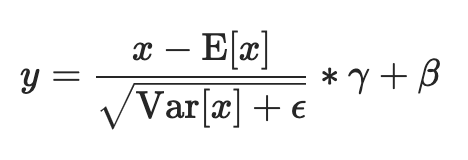

In [244]:
#https://github.com/pytorch/pytorch/issues/7577
mean = inputs.view(3,-1)
running_mean = torch.mean(mean, 1)
var = inputs.view(3,-1)
running_var = torch.var(var, 1)
torch_out =torch.nn.functional.batch_norm(inputs, running_mean, running_var,weight=None, bias=None, training=False, momentum=0.1,eps=1e-05)
#torch_out = torch_out.numpy()
torch_out.shape
#torch_out =np.around(torch_out, decimals=1, out=None)

torch.Size([1, 3, 32, 32])

In [245]:
def batchnorm_forward(x,  running_mean, running_var, mode , momentum,eps ):
    N, C, H, W = x.shape
    out= None
    if mode == 'train':
        sample_mean = running_mean
        sample_var = running_var

        # Normalization followed by Affine transformation
        x_normalized = (x[0,:,:,:] - sample_mean.reshape(( 1,C, 1, 1)))/np.sqrt(sample_var.reshape(( 1,C, 1, 1)) + eps)
        out = x_normalized

        # Estimate running average of mean and variance to use at test time
        running_mean = momentum * running_mean + (1 - momentum) * sample_mean
        running_var = momentum * running_var + (1 - momentum) * sample_var
        
    elif mode == 'test':
        # normalize using running average
        running_mean = momentum * running_mean + (1 - momentum) * running_mean
        running_var = momentum * running_var + (1 - momentum) * running_var
        x_normalized = (x[0,:,:,:] - running_mean.reshape(( 1,C, 1, 1)))/np.sqrt(running_var.reshape((1, C, 1, 1)) + eps)
        # Learned affine transformation
        out = x_normalized 
    return out
running_mean = running_mean.numpy()
running_var = running_var.numpy()
my_out = batchnorm_forward(input_np,  running_mean, running_var,  'test', 0.1,1e-05 )
#my_out = np.around(my_out, decimals=1, out=None)
my_out.shape

(1, 3, 32, 32)

In [246]:
(torch_out - my_out<=0.000001).all()

tensor(True)

### 10. Cross Entropy

This criterion combines LogSoftmax and NLLLoss in one single class.

It is useful when training a classification problem with C classes, calculating the probability of each class for an input between 0 and 1 (sum up to 1), 

The loss of one class is:
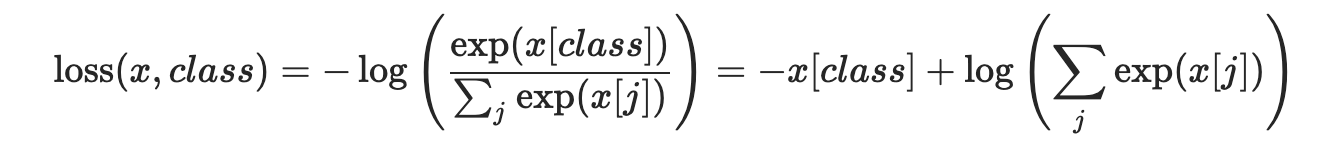
Then the losses are averaged with weights(if no weights, then normal average):
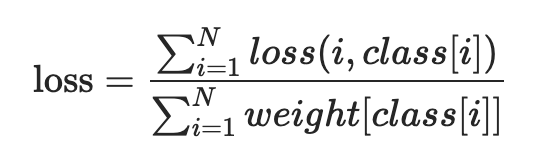

In [154]:
#target = torch.randint(1, 32, 32)
#target = target.type(torch.LongTensor)
target = torch.randint(3, (1,32,32), dtype=torch.int64)
torch_out = torch.nn.functional.cross_entropy(inputs, target, weight=None,
size_average=None, ignore_index=-100, reduce=None,reduction='mean')
torch_out                                              

tensor(1.3753)

In [188]:
def compute_loss(softmax, target):
    loss_list = torch.zeros([len(input)])
    for k in range(len(softmax)):
        loss = 0
        for i in range(target[k].shape[1]):
            for j in range(target.shape[2]):
                index = target[k, i, j]
                num = softmax[k, index, i ,j]
                loss -= num
        loss_list[k] = -loss / target.shape[1] / target.shape[2]
    return loss_list.mean()

def cross_entropy(x, target):
    #compute softmax
    x_log_softmax = torch.zeros(x.shape)
    for i in range(len(x)):
        exp = torch.exp(x[i])
        sum = torch.sum(exp, dim=0)
        softmax = exp/sum
        x_log_softmax[i] = -torch.log(softmax)

    ce = compute_loss(x_log_softmax, target)
    return ce
my_out = cross_entropy(inputs, target)
my_out

tensor(1.3753)

In [180]:
torch_out == my_out

tensor(True)

### 11. MSE Loss ( mean squared error between inputs and target)

In [40]:
target = torch.randn(1,3, 32, 32)
#Input: (N, *)(N,∗) where *∗ means, any number of additional dimensions
#Target: (N, *)(N,∗) , same shape as the input
torch_out =torch.nn.functional.mse_loss(inputs, target, size_average=None,reduce=None, reduction='mean')
torch_out                                             

tensor(1.9750)

In [44]:
def mse_loss(input, target):
    square = (input - target)**2
    return square.mean()
my_out = mse_loss(inputs, target)
print(my_out)

tensor(1.9750)


In [45]:
torch_out == my_out

tensor(True)